# Data Preparation

In [14]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import pylab

from scipy import ndimage
from skimage import morphology

import pandas as pd
import os

%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [15]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [16]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [17]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)

    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

In [18]:
def tiltCorrection(maskedImage):
    
    img=np.uint8 (maskedImage)
    contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask=np.zeros (img.shape, np.uint8)

    # find the biggest contour (c) by the area
    c = max(contours, key = cv2.contourArea)

    (x,y),(MA,ma),angle = cv2.fitEllipse(c)

    cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

    rmajor = max(MA,ma)/2
    if angle > 90:
        angle -= 90
    else:
        angle += 96
    xtop = x + math.cos(math.radians(angle))*rmajor
    ytop = y + math.sin(math.radians(angle))*rmajor
    xbot = x + math.cos(math.radians(angle+180))*rmajor
    ybot = y + math.sin(math.radians(angle+180))*rmajor
    cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

    M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

    return img

In [19]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image

In [20]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

## Show images

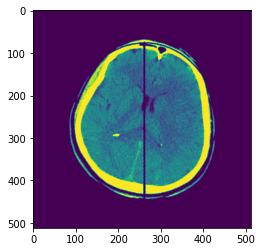

In [21]:
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/10105.dcm"

maskedImage = remove_noise(dicomFile, display=False)
tiltCorrectedImage = tiltCorrection(maskedImage)
croppedImage = crop_image(tiltCorrectedImage)
final_image = add_pad(croppedImage)

plt.imshow(final_image)

In [22]:
print('Shape: ', final_image.shape)
print('Max pixel value: ', final_image.max())
print('Min pixel value: ', final_image.min())

Shape:  (512, 512)
Max pixel value:  80.0
Min pixel value:  0.0


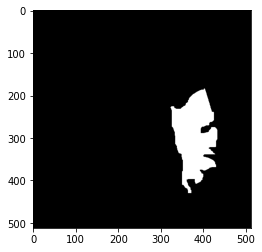

In [23]:
sample_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/10105.png'

# read the mask using skimage
mask = imread(sample_mask)

plt.imshow(mask, cmap='gray')

In [24]:
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())

Shape:  (512, 512)
Max pixel value:  1
Min pixel value:  0


## Create X-train Y-train X-test Y-test

In [25]:
images_paths = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/")
masks_paths = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/")

In [26]:
images_paths2 = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/")
masks_paths2 = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/")

In [27]:
len(images_paths), len(masks_paths)

(1130, 1130)

In [28]:
len(images_paths2), len(masks_paths2)

(1091, 1091)

In [29]:
images_paths.sort()
images_paths2.sort()
masks_paths.sort()
masks_paths2.sort()

In [30]:
val_size = int(len(images_paths) * .20)
val_size

226

In [31]:
X_trainFirst = images_paths[val_size:]
X_testFirst = images_paths[:val_size]
Y_trainFirst = masks_paths[val_size:]  # Burada Onemli birsey var!!! Ayni mi acaba maskeler?
Y_testFirst = masks_paths[:val_size]

In [32]:
len(X_trainFirst), len(X_testFirst), len(Y_trainFirst), len(Y_testFirst)

(904, 226, 904, 226)

In [33]:
val_size2 = int(len(images_paths2) * .20)
val_size2

218

In [34]:
X_train = images_paths2[val_size2:]
X_test = images_paths2[:val_size2]
Y_train = masks_paths2[val_size2:]  # Burada Onemli birsey var!!! Ayni mi acaba maskeler?
Y_test = masks_paths2[:val_size2]

In [35]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(873, 218, 873, 218)

In [36]:
MainX_train = X_trainFirst + X_train
MainX_test = X_testFirst + X_test
MainY_train = Y_trainFirst + Y_train
MainY_test = Y_testFirst + Y_test

In [37]:
MainX_train[0], MainY_train[0]

('11377.dcm', '11377.png')

In [38]:
MainX_train[1203], MainY_train[1203]

('13290.dcm', '13290.png')

In [39]:
MainX_train[1768], MainY_train[1768]

('16973.dcm', '16973.png')

In [40]:
MainX_test[0], MainY_test[0]

('10003.dcm', '10003.png')

In [41]:
MainX_test[205], MainY_test[205]

('11282.dcm', '11282.png')

In [42]:
MainX_test[400], MainY_test[400]

('11136.dcm', '11136.png')

**Ohh bee hepsi ayni**

**SIMDI ELIMIZDE LIST VAR AMA BU SADECE STRING OLARAK VAR, BIZ SIMDI BU LISTEYE DIREKT IMAGELARI ALACAGIZ**

## Image Lists olarak X-train'leri olusturma

In [43]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1

In [44]:
# Get lists of images and their masks.
image_id_list = MainX_train
mask_id_list = MainY_train
test_id_list = MainX_test
testMask_id_list = MainY_test


# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [45]:
len(X_train), len(Y_train), len(X_test), len(Y_test)

(1777, 1777, 444, 444)

In [46]:
# X_train

count=0

for i, image_id in enumerate(image_id_list):
    
    
    try:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + image_id
        f = open(path_image)
        flag=1
    except IOError:
        print("File not accessible")
        flag=2
    finally:
        f.close()
    
    
    if flag == 1:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + image_id
    elif flag == 2:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/' + image_id
    
    print(image_id)
    
    maskedImage = remove_noise(path_image, display=False)
    tiltCorrectedImage = tiltCorrection(maskedImage)
    croppedImage = crop_image(tiltCorrectedImage)
    
    while croppedImage.shape[0] > 512 or croppedImage.shape[1] > 512 :
        src = croppedImage
        #percent by which the image is resized
        scale_percent = 75
        #calculate the 50 percent of original dimensions
        width = int(src.shape[1] * scale_percent / 100)
        height = int(src.shape[0] * scale_percent / 100)
        # dsize
        dsize = (width, height)
        # resize image
        output = cv2.resize(src, dsize)
        croppedImage = output
    
    final_image = add_pad(croppedImage)
    
    # ????????? use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(final_image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    print(i)
    
    count+=1
    
X_train.shape

11377.dcm
0
11380.dcm
1
11381.dcm
2
11390.dcm
3
11393.dcm
4
11399.dcm
5
11403.dcm
6
11417.dcm
7
11424.dcm
8
11427.dcm
9
11430.dcm
10
11432.dcm
11
11433.dcm
12
11443.dcm
13
11457.dcm
14
11466.dcm
15
11471.dcm
16
11478.dcm
17
11480.dcm
18
11485.dcm
19
11490.dcm
20
11492.dcm
21
11504.dcm
22
11521.dcm
23
11536.dcm
24
11545.dcm
25
11551.dcm
26
11552.dcm
27
11554.dcm
28
11556.dcm
29
11562.dcm
30
11565.dcm
31
11569.dcm
32
11570.dcm
33
11574.dcm
34
11579.dcm
35
11580.dcm
36
11597.dcm
37
11617.dcm
38
11624.dcm
39
11626.dcm
40
11629.dcm
41
11635.dcm
42
11638.dcm
43
11639.dcm
44
11640.dcm
45
11642.dcm
46
11655.dcm
47
11657.dcm
48
11663.dcm
49
11680.dcm
50
11686.dcm
51
11689.dcm
52
11695.dcm
53
11721.dcm
54
11723.dcm
55
11726.dcm
56
11729.dcm
57
11733.dcm
58
11734.dcm
59
11756.dcm
60
11767.dcm
61
11781.dcm
62
11799.dcm
63
11813.dcm
64
11821.dcm
65
11829.dcm
66
11858.dcm
67
11860.dcm
68
11868.dcm
69
11871.dcm
70
11896.dcm
71
11900.dcm
72
11905.dcm
73
11933.dcm
74
11936.dcm
75
11946.dcm
76
11955.dcm

593
15278.dcm
594
15283.dcm
595
15287.dcm
596
15299.dcm
597
15306.dcm
598
15328.dcm
599
15331.dcm
600
15336.dcm
601
15337.dcm
602
15343.dcm
603
15347.dcm
604
15348.dcm
605
15349.dcm
606
15355.dcm
607
15361.dcm
608
15370.dcm
609
15371.dcm
610
15375.dcm
611
15380.dcm
612
15403.dcm
613
15408.dcm
614
15410.dcm
615
15412.dcm
616
15413.dcm
617
15416.dcm
618
15423.dcm
619
15426.dcm
620
15433.dcm
621
15438.dcm
622
15439.dcm
623
15450.dcm
624
15456.dcm
625
15458.dcm
626
15459.dcm
627
15467.dcm
628
15477.dcm
629
15481.dcm
630
15483.dcm
631
15486.dcm
632
15498.dcm
633
15507.dcm
634
15514.dcm
635
15520.dcm
636
15525.dcm
637
15527.dcm
638
15539.dcm
639
15547.dcm
640
15551.dcm
641
15560.dcm
642
15571.dcm
643
15588.dcm
644
15601.dcm
645
15603.dcm
646
15610.dcm
647
15611.dcm
648
15620.dcm
649
15625.dcm
650
15626.dcm
651
15628.dcm
652
15633.dcm
653
15635.dcm
654
15640.dcm
655
15650.dcm
656
15665.dcm
657
15672.dcm
658
15674.dcm
659
15676.dcm
660
15677.dcm
661
15679.dcm
662
15681.dcm
663
15682.dcm
664
15

1019
File not accessible
12231.dcm
1020
File not accessible
12241.dcm
1021
File not accessible
12243.dcm
1022
File not accessible
12254.dcm
1023
File not accessible
12262.dcm
1024
File not accessible
12266.dcm
1025
File not accessible
12270.dcm
1026
File not accessible
12271.dcm
1027
File not accessible
12274.dcm
1028
File not accessible
12275.dcm
1029
File not accessible
12276.dcm
1030
File not accessible
12278.dcm
1031
File not accessible
12281.dcm
1032
File not accessible
12283.dcm
1033
File not accessible
12284.dcm
1034
File not accessible
12287.dcm
1035
File not accessible
12297.dcm
1036
File not accessible
12303.dcm
1037
File not accessible
12312.dcm
1038
File not accessible
12314.dcm
1039
File not accessible
12315.dcm
1040
File not accessible
12324.dcm
1041
File not accessible
12339.dcm
1042
File not accessible
12341.dcm
1043
File not accessible
12343.dcm
1044
File not accessible
12348.dcm
1045
File not accessible
12351.dcm
1046
File not accessible
12356.dcm
1047
File not access

1255
File not accessible
13639.dcm
1256
File not accessible
13641.dcm
1257
File not accessible
13642.dcm
1258
File not accessible
13647.dcm
1259
File not accessible
13664.dcm
1260
File not accessible
13675.dcm
1261
File not accessible
13682.dcm
1262
File not accessible
13694.dcm
1263
File not accessible
13695.dcm
1264
File not accessible
13710.dcm
1265
File not accessible
13712.dcm
1266
File not accessible
13714.dcm
1267
File not accessible
13716.dcm
1268
File not accessible
13722.dcm
1269
File not accessible
13734.dcm
1270
File not accessible
13749.dcm
1271
File not accessible
13751.dcm
1272
File not accessible
13762.dcm
1273
File not accessible
13764.dcm
1274
File not accessible
13774.dcm
1275
File not accessible
13780.dcm
1276
File not accessible
13799.dcm
1277
File not accessible
13806.dcm
1278
File not accessible
13814.dcm
1279
File not accessible
13815.dcm
1280
File not accessible
13817.dcm
1281
File not accessible
13819.dcm
1282
File not accessible
13821.dcm
1283
File not access

1493
File not accessible
15198.dcm
1494
File not accessible
15203.dcm
1495
File not accessible
15209.dcm
1496
File not accessible
15224.dcm
1497
File not accessible
15226.dcm
1498
File not accessible
15234.dcm
1499
File not accessible
15241.dcm
1500
File not accessible
15246.dcm
1501
File not accessible
15257.dcm
1502
File not accessible
15272.dcm
1503
File not accessible
15286.dcm
1504
File not accessible
15292.dcm
1505
File not accessible
15302.dcm
1506
File not accessible
15305.dcm
1507
File not accessible
15313.dcm
1508
File not accessible
15315.dcm
1509
File not accessible
15330.dcm
1510
File not accessible
15332.dcm
1511
File not accessible
15335.dcm
1512
File not accessible
15338.dcm
1513
File not accessible
15351.dcm
1514
File not accessible
15353.dcm
1515
File not accessible
15356.dcm
1516
File not accessible
15360.dcm
1517
File not accessible
15372.dcm
1518
File not accessible
15376.dcm
1519
File not accessible
15384.dcm
1520
File not accessible
15386.dcm
1521
File not access

1728
File not accessible
16695.dcm
1729
File not accessible
16701.dcm
1730
File not accessible
16703.dcm
1731
File not accessible
16714.dcm
1732
File not accessible
16722.dcm
1733
File not accessible
16744.dcm
1734
File not accessible
16746.dcm
1735
File not accessible
16747.dcm
1736
File not accessible
16756.dcm
1737
File not accessible
16769.dcm
1738
File not accessible
16780.dcm
1739
File not accessible
16790.dcm
1740
File not accessible
16799.dcm
1741
File not accessible
16806.dcm
1742
File not accessible
16807.dcm
1743
File not accessible
16811.dcm
1744
File not accessible
16817.dcm
1745
File not accessible
16818.dcm
1746
File not accessible
16819.dcm
1747
File not accessible
16824.dcm
1748
File not accessible
16844.dcm
1749
File not accessible
16859.dcm
1750
File not accessible
16860.dcm
1751
File not accessible
16861.dcm
1752
File not accessible
16862.dcm
1753
File not accessible
16866.dcm
1754
File not accessible
16867.dcm
1755
File not accessible
16886.dcm
1756
File not access

(1777, 512, 512, 1)

In [47]:
len(X_train), len(Y_train), len(X_test), len(Y_test)

(1777, 1777, 444, 444)

In [48]:
X_train.shape

(1777, 512, 512, 1)

In [49]:
# Y_train

for i, mask_id in enumerate(mask_id_list):
    
    try:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
        f = open(path_mask)
        flag=1
    except IOError:
        print("File not accessible")
        flag=2
    finally:
        f.close()
    
    
    if flag == 1:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
    elif flag == 2:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/' + mask_id
    
    print(mask_id)
    print(i)
        
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

11377.png
0
11380.png
1
11381.png
2
11390.png
3
11393.png
4
11399.png
5
11403.png
6
11417.png
7
11424.png
8
11427.png
9
11430.png
10
11432.png
11
11433.png
12
11443.png
13
11457.png
14
11466.png
15
11471.png
16
11478.png
17
11480.png
18
11485.png
19
11490.png
20
11492.png
21
11504.png
22
11521.png
23
11536.png
24
11545.png
25
11551.png
26
11552.png
27
11554.png
28
11556.png
29
11562.png
30
11565.png
31
11569.png
32
11570.png
33
11574.png
34
11579.png
35
11580.png
36
11597.png
37
11617.png
38
11624.png
39
11626.png
40
11629.png
41
11635.png
42
11638.png
43
11639.png
44
11640.png
45
11642.png
46
11655.png
47
11657.png
48
11663.png
49
11680.png
50
11686.png
51
11689.png
52
11695.png
53
11721.png
54
11723.png
55
11726.png
56
11729.png
57
11733.png
58
11734.png
59
11756.png
60
11767.png
61
11781.png
62
11799.png
63
11813.png
64
11821.png
65
11829.png
66
11858.png
67
11860.png
68
11868.png
69
11871.png
70
11896.png
71
11900.png
72
11905.png
73
11933.png
74
11936.png
75
11946.png
76
11955.png

15328.png
599
15331.png
600
15336.png
601
15337.png
602
15343.png
603
15347.png
604
15348.png
605
15349.png
606
15355.png
607
15361.png
608
15370.png
609
15371.png
610
15375.png
611
15380.png
612
15403.png
613
15408.png
614
15410.png
615
15412.png
616
15413.png
617
15416.png
618
15423.png
619
15426.png
620
15433.png
621
15438.png
622
15439.png
623
15450.png
624
15456.png
625
15458.png
626
15459.png
627
15467.png
628
15477.png
629
15481.png
630
15483.png
631
15486.png
632
15498.png
633
15507.png
634
15514.png
635
15520.png
636
15525.png
637
15527.png
638
15539.png
639
15547.png
640
15551.png
641
15560.png
642
15571.png
643
15588.png
644
15601.png
645
15603.png
646
15610.png
647
15611.png
648
15620.png
649
15625.png
650
15626.png
651
15628.png
652
15633.png
653
15635.png
654
15640.png
655
15650.png
656
15665.png
657
15672.png
658
15674.png
659
15676.png
660
15677.png
661
15679.png
662
15681.png
663
15682.png
664
15683.png
665
15686.png
666
15688.png
667
15689.png
668
15695.png
669
15698.

File not accessible
12262.png
1024
File not accessible
12266.png
1025
File not accessible
12270.png
1026
File not accessible
12271.png
1027
File not accessible
12274.png
1028
File not accessible
12275.png
1029
File not accessible
12276.png
1030
File not accessible
12278.png
1031
File not accessible
12281.png
1032
File not accessible
12283.png
1033
File not accessible
12284.png
1034
File not accessible
12287.png
1035
File not accessible
12297.png
1036
File not accessible
12303.png
1037
File not accessible
12312.png
1038
File not accessible
12314.png
1039
File not accessible
12315.png
1040
File not accessible
12324.png
1041
File not accessible
12339.png
1042
File not accessible
12341.png
1043
File not accessible
12343.png
1044
File not accessible
12348.png
1045
File not accessible
12351.png
1046
File not accessible
12356.png
1047
File not accessible
12358.png
1048
File not accessible
12361.png
1049
File not accessible
12365.png
1050
File not accessible
12371.png
1051
File not accessible


File not accessible
13647.png
1259
File not accessible
13664.png
1260
File not accessible
13675.png
1261
File not accessible
13682.png
1262
File not accessible
13694.png
1263
File not accessible
13695.png
1264
File not accessible
13710.png
1265
File not accessible
13712.png
1266
File not accessible
13714.png
1267
File not accessible
13716.png
1268
File not accessible
13722.png
1269
File not accessible
13734.png
1270
File not accessible
13749.png
1271
File not accessible
13751.png
1272
File not accessible
13762.png
1273
File not accessible
13764.png
1274
File not accessible
13774.png
1275
File not accessible
13780.png
1276
File not accessible
13799.png
1277
File not accessible
13806.png
1278
File not accessible
13814.png
1279
File not accessible
13815.png
1280
File not accessible
13817.png
1281
File not accessible
13819.png
1282
File not accessible
13821.png
1283
File not accessible
13823.png
1284
File not accessible
13825.png
1285
File not accessible
13829.png
1286
File not accessible


File not accessible
15292.png
1505
File not accessible
15302.png
1506
File not accessible
15305.png
1507
File not accessible
15313.png
1508
File not accessible
15315.png
1509
File not accessible
15330.png
1510
File not accessible
15332.png
1511
File not accessible
15335.png
1512
File not accessible
15338.png
1513
File not accessible
15351.png
1514
File not accessible
15353.png
1515
File not accessible
15356.png
1516
File not accessible
15360.png
1517
File not accessible
15372.png
1518
File not accessible
15376.png
1519
File not accessible
15384.png
1520
File not accessible
15386.png
1521
File not accessible
15391.png
1522
File not accessible
15392.png
1523
File not accessible
15393.png
1524
File not accessible
15394.png
1525
File not accessible
15396.png
1526
File not accessible
15398.png
1527
File not accessible
15430.png
1528
File not accessible
15444.png
1529
File not accessible
15445.png
1530
File not accessible
15448.png
1531
File not accessible
15455.png
1532
File not accessible


File not accessible
16866.png
1754
File not accessible
16867.png
1755
File not accessible
16886.png
1756
File not accessible
16889.png
1757
File not accessible
16892.png
1758
File not accessible
16910.png
1759
File not accessible
16916.png
1760
File not accessible
16940.png
1761
File not accessible
16950.png
1762
File not accessible
16952.png
1763
File not accessible
16955.png
1764
File not accessible
16962.png
1765
File not accessible
16966.png
1766
File not accessible
16968.png
1767
File not accessible
16973.png
1768
File not accessible
16976.png
1769
File not accessible
16996.png
1770
File not accessible
17000.png
1771
File not accessible
17009.png
1772
File not accessible
17011.png
1773
File not accessible
17016.png
1774
File not accessible
17027.png
1775
File not accessible
17028.png
1776


(1777, 512, 512, 1)

In [50]:
Y_train.shape

(1777, 512, 512, 1)

In [51]:
# X_test

count=0

for i, image_id in enumerate(test_id_list):
    
    
    try:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + image_id
        f = open(path_image)
        flag=1
    except IOError:
        print("File not accessible")
        flag=2
    finally:
        f.close()
    
    
    if flag == 1:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + image_id
    elif flag == 2:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/' + image_id
    
    print(image_id)
    
    maskedImage = remove_noise(path_image, display=False)
    tiltCorrectedImage = tiltCorrection(maskedImage)
    croppedImage = crop_image(tiltCorrectedImage)
    
    while croppedImage.shape[0] > 512 or croppedImage.shape[1] > 512 :
        src = croppedImage
        #percent by which the image is resized
        scale_percent = 75
        #calculate the 50 percent of original dimensions
        width = int(src.shape[1] * scale_percent / 100)
        height = int(src.shape[0] * scale_percent / 100)
        # dsize
        dsize = (width, height)
        # resize image
        output = cv2.resize(src, dsize)
        croppedImage = output
    
    final_image = add_pad(croppedImage)
    
    # ????????? use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(final_image, axis=-1)
    
    # insert the image into X_train
    X_test[i] = image
    print(i)
    
    count+=1
    
X_test.shape


10003.dcm
0
10017.dcm
1
10024.dcm
2
10028.dcm
3
10038.dcm
4
10053.dcm
5
10059.dcm
6
10060.dcm
7
10062.dcm
8
10072.dcm
9
10073.dcm
10
10077.dcm
11
10088.dcm
12
10095.dcm
13
10101.dcm
14
10105.dcm
15
10108.dcm
16
10123.dcm
17
10145.dcm
18
10151.dcm
19
10153.dcm
20
10158.dcm
21
10160.dcm
22
10164.dcm
23
10179.dcm
24
10181.dcm
25
10187.dcm
26
10188.dcm
27
10202.dcm
28
10206.dcm
29
10209.dcm
30
10227.dcm
31
10236.dcm
32
10238.dcm
33
10242.dcm
34
10248.dcm
35
10262.dcm
36
10263.dcm
37
10268.dcm
38
10273.dcm
39
10280.dcm
40
10289.dcm
41
10290.dcm
42
10296.dcm
43
10298.dcm
44
10307.dcm
45
10323.dcm
46
10351.dcm
47
10354.dcm
48
10355.dcm
49
10356.dcm
50
10363.dcm
51
10364.dcm
52
10367.dcm
53
10372.dcm
54
10377.dcm
55
10391.dcm
56
10399.dcm
57
10403.dcm
58
10418.dcm
59
10436.dcm
60
10438.dcm
61
10444.dcm
62
10446.dcm
63
10447.dcm
64
10448.dcm
65
10453.dcm
66
10459.dcm
67
10460.dcm
68
10466.dcm
69
10477.dcm
70
10479.dcm
71
10485.dcm
72
10486.dcm
73
10487.dcm
74
10489.dcm
75
10499.dcm
76
10507.dcm

379
File not accessible
10986.dcm
380
File not accessible
10987.dcm
381
File not accessible
10990.dcm
382
File not accessible
10997.dcm
383
File not accessible
11004.dcm
384
File not accessible
11015.dcm
385
File not accessible
11016.dcm
386
File not accessible
11021.dcm
387
File not accessible
11039.dcm
388
File not accessible
11048.dcm
389
File not accessible
11049.dcm
390
File not accessible
11059.dcm
391
File not accessible
11065.dcm
392
File not accessible
11090.dcm
393
File not accessible
11112.dcm
394
File not accessible
11117.dcm
395
File not accessible
11119.dcm
396
File not accessible
11123.dcm
397
File not accessible
11124.dcm
398
File not accessible
11128.dcm
399
File not accessible
11136.dcm
400
File not accessible
11137.dcm
401
File not accessible
11143.dcm
402
File not accessible
11145.dcm
403
File not accessible
11162.dcm
404
File not accessible
11170.dcm
405
File not accessible
11179.dcm
406
File not accessible
11180.dcm
407
File not accessible
11181.dcm
408
File not a

(444, 512, 512, 1)

In [52]:
X_test.shape

(444, 512, 512, 1)

In [53]:
# Y_test

for i, mask_id in enumerate(testMask_id_list):
    
    try:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
        f = open(path_mask)
        flag=1
    except IOError:
        print("File not accessible")
        flag=2
    finally:
        f.close()
    
    
    if flag == 1:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
    elif flag == 2:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/' + mask_id
    
    print(mask_id)
    print(i)
        
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_test[i] = mask

Y_test.shape

10003.png
0
10017.png
1
10024.png
2
10028.png
3
10038.png
4
10053.png
5
10059.png
6
10060.png
7
10062.png
8
10072.png
9
10073.png
10
10077.png
11
10088.png
12
10095.png
13
10101.png
14
10105.png
15
10108.png
16
10123.png
17
10145.png
18
10151.png
19
10153.png
20
10158.png
21
10160.png
22
10164.png
23
10179.png
24
10181.png
25
10187.png
26
10188.png
27
10202.png
28
10206.png
29
10209.png
30
10227.png
31
10236.png
32
10238.png
33
10242.png
34
10248.png
35
10262.png
36
10263.png
37
10268.png
38
10273.png
39
10280.png
40
10289.png
41
10290.png
42
10296.png
43
10298.png
44
10307.png
45
10323.png
46
10351.png
47
10354.png
48
10355.png
49
10356.png
50
10363.png
51
10364.png
52
10367.png
53
10372.png
54
10377.png
55
10391.png
56
10399.png
57
10403.png
58
10418.png
59
10436.png
60
10438.png
61
10444.png
62
10446.png
63
10447.png
64
10448.png
65
10453.png
66
10459.png
67
10460.png
68
10466.png
69
10477.png
70
10479.png
71
10485.png
72
10486.png
73
10487.png
74
10489.png
75
10499.png
76
10507.png

File not accessible
11065.png
392
File not accessible
11090.png
393
File not accessible
11112.png
394
File not accessible
11117.png
395
File not accessible
11119.png
396
File not accessible
11123.png
397
File not accessible
11124.png
398
File not accessible
11128.png
399
File not accessible
11136.png
400
File not accessible
11137.png
401
File not accessible
11143.png
402
File not accessible
11145.png
403
File not accessible
11162.png
404
File not accessible
11170.png
405
File not accessible
11179.png
406
File not accessible
11180.png
407
File not accessible
11181.png
408
File not accessible
11183.png
409
File not accessible
11193.png
410
File not accessible
11197.png
411
File not accessible
11206.png
412
File not accessible
11208.png
413
File not accessible
11210.png
414
File not accessible
11226.png
415
File not accessible
11227.png
416
File not accessible
11233.png
417
File not accessible
11243.png
418
File not accessible
11248.png
419
File not accessible
11254.png
420
File not acces

(444, 512, 512, 1)

In [54]:
Y_test.shape

(444, 512, 512, 1)

# Model

## Model Architecture

In [55]:
kucukX_train = X_train[:100]
kucukY_train = Y_train[:100]

kucukX_test = X_test[:10]
kucukY_test = Y_test[:10]

In [56]:
kucukY_train.shape

(100, 512, 512, 1)

In [57]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil
import PIL
import pathlib
import pandas as pd
import cv2
from imgaug import augmenters as iaa
import imgaug as ia

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

import re

In [58]:
def downstream_block(layer, number_filters):
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    cropped_feature_map = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    layer = layers.MaxPool2D(2, strides=2, padding='same')(cropped_feature_map)

    return layer, cropped_feature_map

In [59]:
def upstream_block(layer, number_filters, cropped_feature_map):
    layer = layers.Conv2DTranspose(number_filters, (2, 2), strides=(2, 2), padding='same')(layer)
    layer = layers.concatenate([layer, cropped_feature_map])
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)

    return layer

In [60]:
def u_net():
    input = layers.Input(input_shape)
    layer = input

    cropped_feature_maps = []

    for index in range(steps + 1):
        current_number_filters = number_filters * 2 ** index
        layer, cropped_feature_map = downstream_block(layer, current_number_filters)
        cropped_feature_maps.append(cropped_feature_map)

    layer = cropped_feature_maps.pop()

    for index in range(steps - 1, -1, -1):
        current_number_filters = number_filters * 2 ** index
        layer = upstream_block(layer, current_number_filters, cropped_feature_maps[index])

    output = layers.Conv2D(number_classes, 1, activation='sigmoid')(layer)
    model = Model(input, output)

    return model

In [72]:
input_shape = (512, 512, 1)
img_size = 512
number_filters = 16 
steps = 4
number_classes = 1

In [73]:
model = None
model = u_net()

In [74]:
batch_size = 32

learning_rate = 3e-4
epochs = 2

In [75]:
def polynomial_decay(epoch):
    power = 1.0

    alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
    return alpha

In [88]:
filepath="/Users/esmasert/Desktop/modelss/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, 
                                save_weights_only=True, mode='max', period=1)



lr_decay = LearningRateScheduler(polynomial_decay)

In [89]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 256, 256, 16) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [90]:
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['acc'])

In [91]:
train_steps = int(len(kucukX_train) / batch_size)
val_steps = int(len(kucukX_test) / batch_size)

In [92]:
train_steps, val_steps

(3, 0)

In [94]:
# pretrain model decoder
model.fit(kucukX_train, kucukY_train,
          epochs=epochs,
                        steps_per_epoch=train_steps,
                        validation_data=(kucukX_test, kucukY_test),
                        validation_steps=val_steps,
                        verbose=1)


Epoch 1/2
3/3 [==============================] - 187s 62s/step - loss: 0.4582 - acc: 0.9757
Epoch 2/2
3/3 [==============================] - 192s 64s/step - loss: 0.3877 - acc: 0.9751


In [95]:
model.evaluate(kucukX_test, kucukY_test)

1/1 [==============================] - 5s 5s/step - loss: 0.3312 - acc: 0.9768


[0.33118748664855957, 0.9768298864364624]

In [96]:
model.evaluate(X_test, Y_test)

14/14 [==============================] - 164s 12s/step - loss: 0.3130 - acc: 0.9824


[0.3130183219909668, 0.9824047088623047]

In [97]:
# Make a prediction

# use the best epoch
#model.load_weights('/Users/esmasert/Desktop/TrainedCT/model.h5')

test_preds = model.predict(kucukX_test)

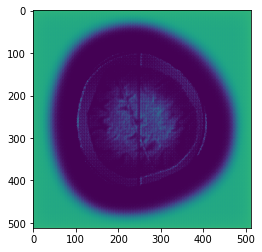

In [98]:
plt.imshow(test_preds[1])

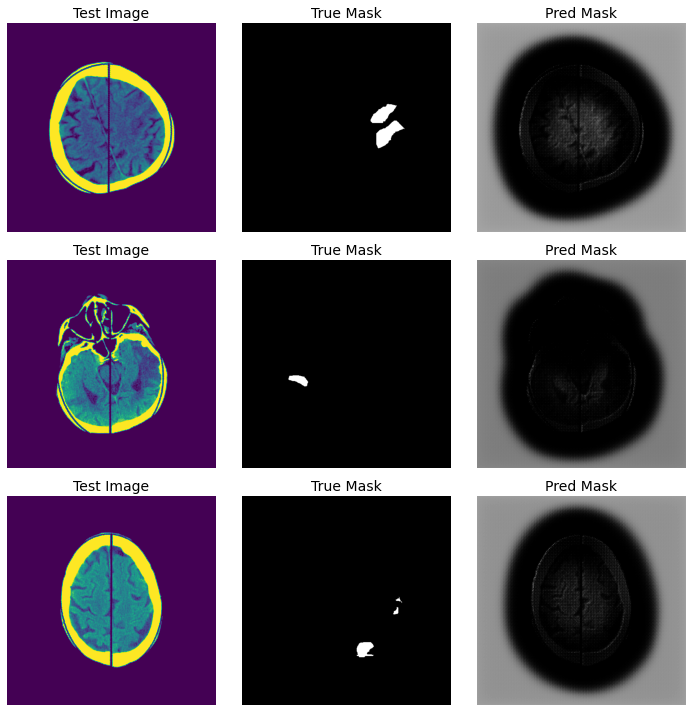

In [99]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = kucukX_test[1]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,2)
mask = kucukY_test[1]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = test_preds[1]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = kucukX_test[2]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask = kucukY_test[2]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = test_preds[2]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = kucukX_test[3]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask = mask = kucukY_test[3]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = test_preds[3]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()

In [76]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io

In [87]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = int(512)
img_cols = int(512)
smooth = 1.
#We divide here the number of rows and columns by two because we undersample our data (We take one pixel over two)

In [89]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    #model.compile('Adam', loss=dice_coef_loss, metrics=[dice_coef])
    
    model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

    return model

#The different layers in our neural network model (including convolutions, maxpooling and upsampling)

In [90]:
model = get_unet()

model.summary()



Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 512, 512, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 256, 256, 32) 0           conv2d_58[0][0]                  
____________________________________________________________________________________________

In [91]:
# pretrain model decoder
model.fit(kucukX_train, kucukY_train, epochs=2, validation_data=(kucukX_test, kucukY_test))

Epoch 1/2
4/4 [==============================] - 707s 171s/step - loss: 0.7347 - binary_accuracy: 0.7140 - val_loss: 0.5320 - val_binary_accuracy: 0.9765
Epoch 2/2
4/4 [==============================] - 790s 164s/step - loss: 0.5470 - binary_accuracy: 0.9756 - val_loss: 0.4303 - val_binary_accuracy: 0.9769


In [92]:
model.evaluate(kucukX_test, kucukY_test)

1/1 [==============================] - 16s 16s/step - loss: 0.4303 - binary_accuracy: 0.9769


[0.4302571713924408, 0.9768993258476257]

In [93]:
# Make a prediction

# use the best epoch
#model.load_weights('/Users/esmasert/Desktop/TrainedCT/model.h5')

test_preds = model.predict(kucukX_test)

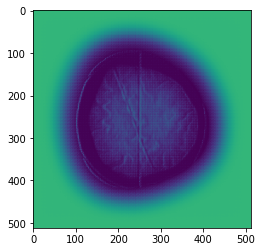

In [95]:
plt.imshow(test_preds[1])

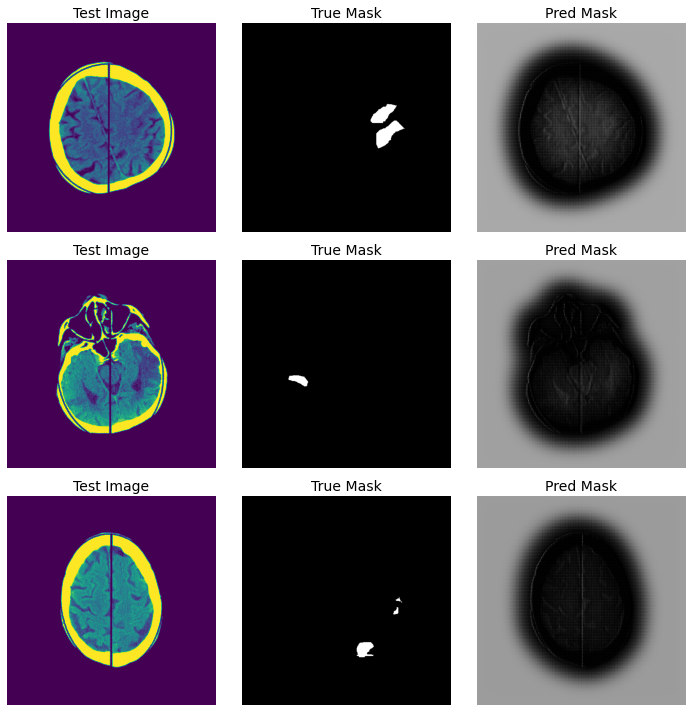

In [97]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = kucukX_test[1]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,2)
mask = kucukY_test[1]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = test_preds[1]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = kucukX_test[2]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask = kucukY_test[2]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = test_preds[2]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = kucukX_test[3]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask = mask = kucukY_test[3]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = test_preds[3]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()

In [69]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 64)      36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 984064)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [ ]:
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

# pretrain model decoder
model.fit(kucukX_train, kucukY_train, epochs=2, validation_data=(kucukX_test, kucukY_test))


In [55]:
model.evaluate(kucukX_test, kucukY_test)

1/1 [==============================] - 7s 7s/step - loss: 605624.5000 - binary_accuracy: 0.1091


[605624.5, 0.1091487854719162]

In [57]:
# Make a prediction

# use the best epoch
#model.load_weights('/Users/esmasert/Desktop/TrainedCT/model.h5')

test_preds = model.predict(kucukX_test)

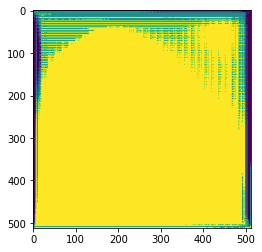

In [60]:
plt.imshow(test_preds[1])

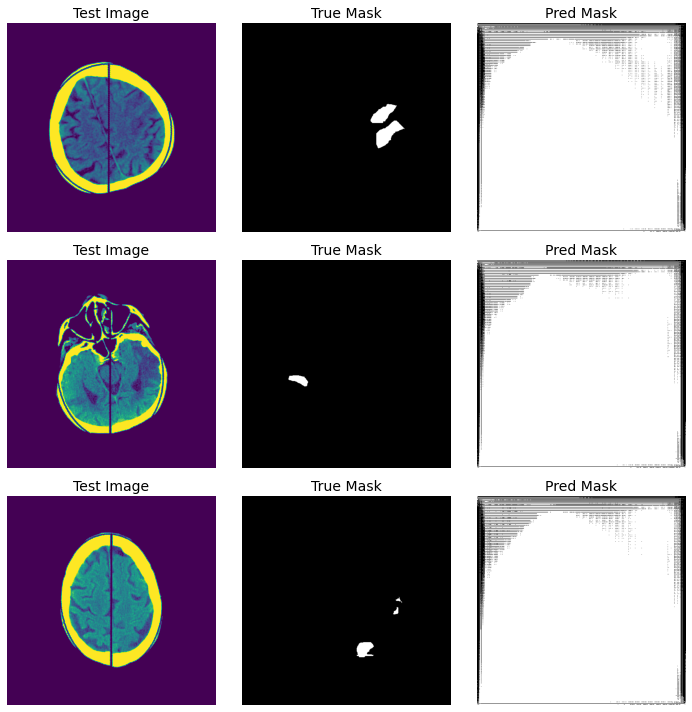

In [61]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = kucukX_test[1]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,2)
mask = kucukY_test[1]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = test_preds[1]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = kucukX_test[2]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask = kucukY_test[2]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = test_preds[2]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = kucukX_test[3]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask = mask = kucukY_test[3]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = test_preds[3]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()